# Adaptation-Classification Framework

## Introduction

The primary objective of [Kitamoto et al. 23] is to identify primary aldosteronism patients who could benefit from certain surgical treatment. From a machine learning perspective, this involves a classification problem to categorize a patient into the surgical track, medication track, or another relevant category. While this may seem like a straightforward classification problem, challenges emerge when multiple clinical institutions are involved, as outlined below.

In a previous study [Kitamoto et al. 20], it was suggested that certain clinical markers effectively distinguish individuals who may benefit from surgical intervention. Some of these markers are technically demanding and can be challenging to obtain due to resource constraints within clinical institutions and other various reasons. Consequently, in a multicenter setting, it is common for datasets collected at different centers to have numerous missing entries in a center-specific manner. This situation is a common real-world challenge when a novel clinical approach is generalized from one center to another.

To tackle this challenge, Kitamoto et al. (2023) introduced an approach called the Adaptation-Classification Framework. The overall concept is straightforward: Using a well-established dataset published in [Kitamoto et al. 20], two models are trained:
- Data adaptation model,
- Patient classification model.

When applying the classification model to unseen patient data collected at another center, the data is first "normalized" using the data adaptation model. This involves imputing missing entries that may follow a center-specific pattern. After filling out the missing entries, the classification model is applied to these unseen patients.

Ideally, the task should be formalized as a multi-task learning problem, where each center has its own classification model. However, it is unrealistic and even risky to allow every center to customize its own classifier using its dataset due to potential dataset bias and a lack of a sufficient number of samples. Instead, the same classification model is reused after filling out the missing entries using the adaptation model. Our approach can be considered a conservative form of **transfer learning** where knowledge transfer only occurs in the data imputation stage, compelling the dataset to share the same principal subspace as the reference dataset.

 * [Kitamoto et al. 23] Kitamoto, T., Idé, T., Tezuka, Y. et al., "Identifying primary aldosteronism patients who require adrenal venous sampling: a multi-center study," Scientific Reports 13, 21722 (2023) [[link](https://doi.org/10.1038/s41598-023-47967-z)].
 * [Kitamoto et al. 20] Kitamoto T., et al., "Precise Mapping of Intra-Adrenal Aldosterone Activities Provides a Novel Surgical Strategy for Primary Aldosteronism," Hypertension, 2020;76(3):976-984 [[link](https://www.ahajournals.org/doi/10.1161/HYPERTENSIONAHA.119.14341)]. 


## Data assumption

The Adaptation-Classification Framework operates within the context of multiple datasets comprising clinical markers from patients independently collected across various medical institutions. Two key datasets are involved: the reference dataset, a well-established collection presented in [Kitamoto et al. 20], and the multicenter cohort. The reference dataset is employed as the training set, while the multicenter cohort serves as both the validation and test datasets.

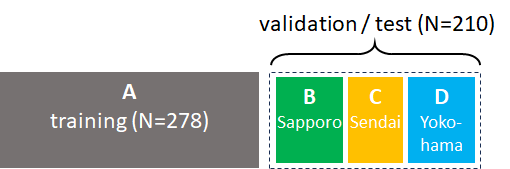


## Classification setting

In [Kitamoto et al. 23], primary aldosteronism was originally to be categorized into three subtypes:
- Surgery-track
- AVS-recommended
- Medication-track

Based on a descriptive analysis illustrated in Figure 2 of the paper, however, the final problem was formalized as two **binary** classification tasks:

1. Classifying "surgery-track" patients from the others.
1. Classifying "medication-track" patients from the others.

Utilizing 36 clinical markers as predictor variables, the objective is to train both a (1) data adaptation model and (2) classification model.

## Preprocess

Common preprocessing steps for both the training and test/validation data include:
- Checking the consistency of variable names and their calibration.
- One-hot encoding of categorical variables.
- Log-transformation of variables with skewed distributions so the distributions become closer to the Gaussian.
- Standardization of each variable for zero mean and unit variance.

### Log transformation

Assuming `X0` is a Pandas DataFrame where rows represent patients, the log-transformation of the `ii`-th variable can be implemented as follows in Python:
```python
	X[:,ii] = np.log(1 + X0.iloc[:,ii])
``` 
This operation produces a numpy array `X`. 

### Standardization

Standardization is performed using the following Python code:
```python
	X = (X - X.mean(axis=0))/X.std(axis=0)
```


## Learning adaptation model

The adaptation model is learned by applying [our BPCA (Bayesian principal component analysis)-based algorithm](https://github.com/Idesan/bpca/blob/main/bmpca_impute.ipynb) to the training data. In Python, the implementation is as follows:
```python
import bpca_impute.bpca_impute as bi
X = Xtrain.T # each sample (patient) in the columns, not rows. 
X_filled, param = bi.impute_bpca_ard(X)
W = param.get('W')
mu = param.get('mu')
```

Note that the data matrix in `bpca_impute()` is defined as colum-based, meaning that each *column* represents a patient. 

## Learning classification model

Training a logistic regression model is straightforward in Python using `sklearn` or any other machine learning library. Here's an example Python implementation with `sklearn`:

```python
from sklearn.linear_model import LogisticRegression

# Example parameters
penalty = 'l2'
C = 4 

# training
clf = LogisticRegression(penalty=penalty,C=C, class_weight='balanced')
clf.fit(Xtrain, ytrain_binary)

# Logistic regression coefficients
coefs = clf.coef_[0]
```

## Applying the adaptation model

Now that we have the classification model based on the training data, let's consider how to apply the model to the test data. The first step is to adapt the test data to the source domain (i.e., the training data). The parameters `W,mu` learned from the training data are used to impute the test data:

```python
Xtest_imputed, _ = bi.impute_transfer(Xtest, W=W, mu=mu)
```
For more details, please refer to another [notebook](https://github.com/Idesan/bpca/blob/main/bmpca_impute.ipynb).

## Applying the classification model

Given the imputed test data, the model's prediction can be computed simply by:

```python
ypred = clf.predict(Xtest_imputed)
```